#### **Output**: all possible sequences in `workspace/all_sequences.json`
# Prepare time series dataset 
- use incomplete data: 
    - sequence starts with OCT
    - in the middle, OCTs may have missing VA values
    - sequence may end with only VA without OCT

**possible extensions**
- in the future, could interpolate VA where possible -> need to do some tests regarding the error that this would cause.

In [1]:
import sys
sys.path.append('../')
from sequences import MeasurementSequence, save_sequences_to_pickle, load_sequences_from_pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time
import matplotlib.colors as mcolors

In [2]:
workspace_dir = '/storage/groups/ml01/workspace/hannah.spitzer/LODE'
longitudinal_data = pd.read_csv(os.path.join(workspace_dir, 'longitudinal_data.csv'), index_col=0)
events = pd.read_csv(os.path.join(workspace_dir, 'longitudinal_events.csv'), index_col=0)

events = events.sort_values('study_date')
events.loc[:,'visus?'] = False
events.loc[:,'oct?'] = False

In [3]:
def calculate_measurement_sequences(grouped_patients, grouped_events):
    """iterate over all groups in grouped_patients and create all possible measurement sequences from this.
    Include events from grouped_events.
    Assumes grouped_patients and grouped_events to be sorted.
    """
    sequences = []
    i = 0
    for name, group in tqdm(grouped_patients):
        # get events for this group
        group_events = None
        try:
            group_events = grouped_events.get_group(name)
        except KeyError as e:
            pass
        
        # get possible start and end ids/dates
        start_ids = np.where(group['oct?'])[0]
        start_dates = np.array(group.iloc[start_ids].study_date)
        end_ids = np.where(group['visus?'])[0]
        end_dates = np.array(group.iloc[end_ids].study_date)
        
        # iterate over all pairs of start/end ids
        for start_id, start_date in zip(start_ids, start_dates):
            for end_id, end_date in zip(end_ids, end_dates):
                if start_id < end_id:
                    # get measurements and events
                    cur_measurements = group.iloc[start_id:end_id+1]
                    if group_events is None:
                        cur_events = None
                    else:
                        # this will include unnecessary events for the last measurement, but that does not hurt
                        cur_events = group_events[group_events.study_date.between(start_date, end_date, inclusive=True)]
                    seq = MeasurementSequence.from_pandas(cur_measurements)
                    seq.add_events_from_pandas(cur_events)
                    sequences.append(seq)
        i += 1 
    return sequences


## Calculate dataset
### With nan values for visual acuity
TODO: there may be duplicates in the calculation of measurement sequences (measurements that do not have an OCT are discarded - this leads to duplicates)

In [ ]:
# filter measurements for which could not calculate features
octs_to_remove = '/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/non_segmented_octs.csv'
# TODO do this!

In [6]:
# get amd and dr patients (sorted by date)
# keep NAN octs and logMARs (can still build sequence from them)
filtered = longitudinal_data.dropna(subset=['diagnosis'])

all_patients = filtered.sort_values('study_date')
# drop all groups that do not have at least one OCT and one logMAR
grouped = all_patients.groupby(['patient_id', 'laterality'])
all_patients = grouped.filter(lambda x: x.oct_path.count()>0 and x.logMAR.count() > 0)

grouped_patients = all_patients.groupby(['patient_id', 'laterality'])
grouped_events = events.groupby(['patient_id', 'laterality'])

In [7]:
start_t = time.time()
sequences = calculate_measurement_sequences(grouped_patients, grouped_events)
end_t = time.time()

print('Operation took {} mins'.format((end_t-start_t)/60))

# save sequences to file to avoid recomputing
save_sequences_to_pickle(os.path.join(workspace_dir, 'all_sequences_dict.pickle'), sequences)


Operation took 55.80740994612376 mins


### excluding nan values for visual acuity

In [4]:
# get amd and dr patients (sorted by date)
# drop nan values for visual acuity and octs
filtered = longitudinal_data.dropna(subset=['diagnosis', 'logMAR', 'oct_path'])

all_patients = filtered.sort_values('study_date')
# drop all groups that do not have at least one OCT and one logMAR
grouped = all_patients.groupby(['patient_id', 'laterality'])
all_patients = grouped.filter(lambda x: x.oct_path.count()>0 and x.logMAR.count() > 0)

grouped_patients = all_patients.groupby(['patient_id', 'laterality'])
grouped_events = events.groupby(['patient_id', 'laterality'])

In [5]:
start_t = time.time()
sequences = calculate_measurement_sequences(grouped_patients, grouped_events)
end_t = time.time()

print('Operation took {} mins'.format((end_t-start_t)/60))

# save sequences to file to avoid recomputing
save_sequences_to_pickle(os.path.join(workspace_dir, 'all_sequences_nona_dict.pickle'), sequences)


Operation took 33.266310167312625 mins


- these are all possible sequences. For training, will select only sequences of length x

## Plots of sequences

In [8]:
sequences = load_sequences_from_pickle(os.path.join(workspace_dir, 'all_sequences_dict.pickle'))

sequences_all = sequences
sequences_amd = [seq for seq in sequences if seq.diagnosis=='AMD']
sequences_dr = [seq for seq in sequences if seq.diagnosis=='DR']

In [11]:
def plot_sequence_length(sequences, ax=None):
    # length of sequences
    if ax is None:
        fig, ax = plt.subplots(1,1)
    len_ts = np.array([len(seq) for seq in sequences])

    ax.hist(len_ts, bins=range(1,60), label='time series length')
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('length')
    
    # print median and max values
    maxval = np.max(len_ts)
    ax.text(0.95,0.95, '#ts total: {}\nmaxlen: {:.0f}'.format(len(len_ts), maxval), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')

    
def _make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plot_sequence_vs_va(sequences, ax=None):
    # line plot of avg number of va values wrt time series length
    if ax is None:
        fig, ax = plt.subplots(1,1)
       
    len_seq = np.array([len(seq) for seq in sequences])
    num_va = np.array([seq.num_next_va for seq in sequences])
    num_inj = np.array([seq.num_injections for seq in sequences])
    lens_sur = np.array([seq.lens_surgery for seq in sequences])
    
    unique, ids = np.unique(len_seq, return_inverse=True)
    avg_va_per_unique = np.array([num_va[np.where(ids == u)].mean() for u in range(len(unique))])
    avg_inj_per_unique = np.array([num_inj[np.where(ids == u)].mean() for u in range(len(unique))])
    avg_lens_sur_per_unique = np.array([lens_sur[np.where(ids == u)].mean() for u in range(len(unique))])

    # plot number of va per length of time series
    #ax.plot(unique, avg_va_per_unique, color='blue')
    #ax.set_ylabel('Avg number of va values', color='blue')
    #ax.set_xlabel('Time series length')
    #ax.tick_params(axis='y', labelcolor='blue')
    
    # plot number of injections per length of time series
    #ax2 = ax.twinx()
    ax2 = ax
    ax2.plot(unique, avg_inj_per_unique, color='blue')
    ax2.set_ylabel('Average number of injections', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # plot probablity of lens surgery
    ax3 = ax.twinx()
    #ax3.spines["right"].set_position(("axes", 1.2))
    #_make_patch_spines_invisible(ax3)
    ax3.spines["right"].set_visible(True)
    ax3.plot(unique, avg_lens_sur_per_unique, color='red')
    ax3.set_ylabel('Lens surgery probability', color='red')
    ax3.tick_params(axis='y', labelcolor='red')
    
    # print probability of lens surgery
    ax.text(0.95,0.95, 'p(lens surgery)={:.2f}'.format(np.mean(avg_lens_sur_per_unique)), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')

def plot_timedelta(sequences, ax=None):
    # number of days between consecutive measurements
    if ax is None:
        fig, ax = plt.subplots(1,1)
    timedelta = []
    for seq in sequences:
        timedelta += [mmt.delta_t for mmt in seq.measurements[:-1]]
    timedelta = np.array(timedelta)
        
    ax.hist(timedelta, range=(1,365), bins=50)
    ax.set_ylabel('Number of measurements')
    ax.set_xlabel('Time delta [days]')
    # print median and max values
    median = np.median(timedelta)
    maxval = np.max(timedelta)
    ax.text(0.95,0.95, 'median: {:.0f} d\nmax: {:.0f} d'.format(median, maxval), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
def plot_injections(sequences, ax=None):
    # histogram of number of series with a certain number of injections
    if ax is None:
        fig, ax = plt.subplots(1,1)
    injections = np.array([seq.num_injections for seq in sequences])
    
    ax.hist(injections, range=(1,18), bins=range(1,19))
    ax.set_xticks(range(1,19))
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('Number of injections')
    # print max value and number of 0 injections
    ax.text(0.95,0.95, 'max: {:.0f}\n#series with 0 injections: {}'.format(np.max(injections), sum(injections==0)), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')


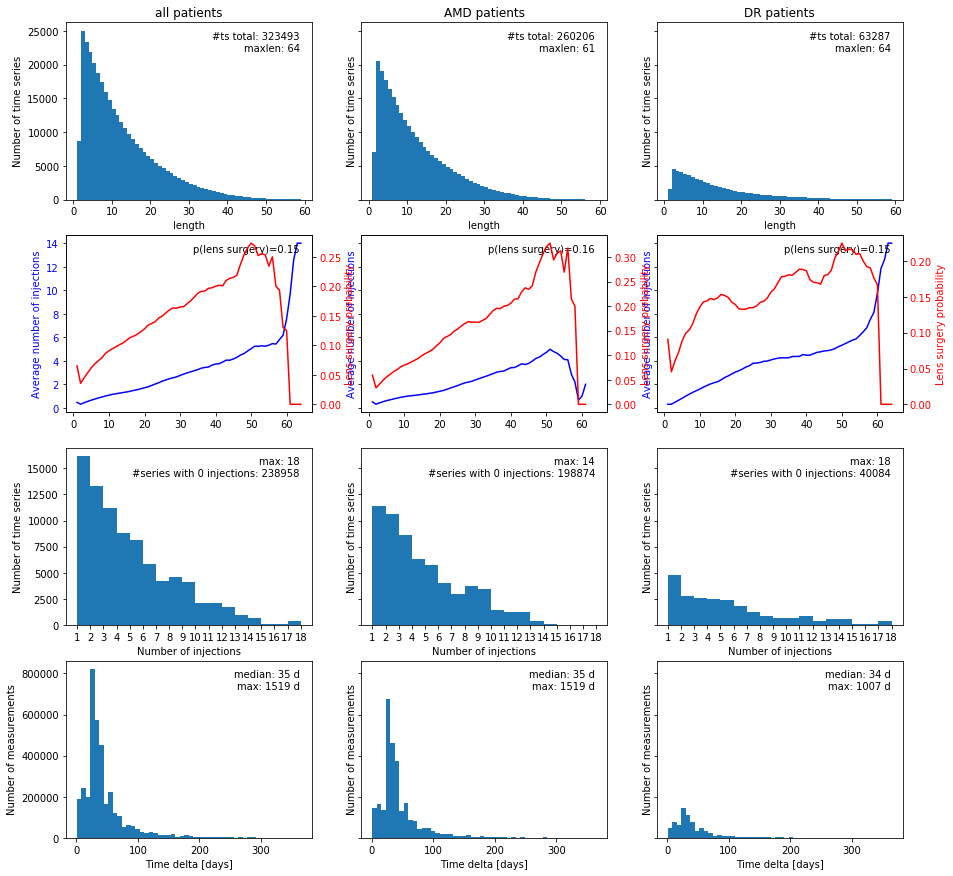

In [12]:
fig, axes = plt.subplots(4,3, sharex='row', sharey='row', figsize=(15,15))
axes[0,1].set_title('AMD patients')
axes[0,0].set_title('all patients')
axes[0,2].set_title('DR patients')
for col, sequences in zip(axes.T, [sequences_all, sequences_amd, sequences_dr]):
    plot_sequence_length(sequences, ax=col[0])
    plot_sequence_vs_va(sequences, ax=col[1])
    plot_injections(sequences, ax=col[2])
    plot_timedelta(sequences, ax=col[3])
fig.savefig('sequences_for_training_oct.png', dpi=300)  

In [18]:
def _get_va_values(seq):
    va = []
    for mmt in seq.measurements:
        if mmt.cur_va is not None:
            va.append(mmt.cur_va)
    if seq.measurements[-1].next_va is not None:
        va.append(seq.measurements[-1].next_va)
    return np.array(va)

def plot_va(sequences, ax=None):
    # histogram of va values distribution
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    logMAR = []
    for seq in sequences:
        logMAR.extend(list(_get_va_values(seq)))
    
    ax.hist(logMAR, bins=np.arange(-0.5,3,0.25))
    ax.set_ylabel('Number of measurements')
    ax.set_xlabel('logMAR (0 good, 2 blind)')
    
def plot_diffva(sequences, ax=None):
    # histogram of va values distribution
    if ax is None:
        fig, ax = plt.subplots(1,1)
    diff_va = []
    for seq in sequences:
        va_values = _get_va_values(seq)
        diff_va.append(float(np.diff(va_values[[0,-1]])))

    ax.hist(diff_va, bins=np.arange(-2,2.5,0.125), alpha=0.5, label='all', density=False)
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('difference between first and last measured logMAR\n(neg: improvement, pos: deterioration)')

def plot_stdva(sequences, ax=None):
    # histogram of va values distribution
    if ax is None:
        fig, ax = plt.subplots(1,1)
    var_va = []
    lens_surgery = []
    all_va = []
    for seq in sequences:
        va_values = _get_va_values(seq)
        var_va.append(float(np.std(va_values)))    
        lens_surgery.append(seq.lens_surgery)
        all_va.extend(va_values)
    
    ax.hist(var_va, bins=np.arange(0,1,0.05), alpha=0.5, label='all', density=False)
    ax.text(0.95,0.95, 'stdev all: {:.03f}\n stdev per ts: {:.03f}'.format(np.std(all_va), np.mean(var_va)), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('variance of logMAR values in one time series')

def plot_va_vs_injection(sequences, ax=None):
    # 2D histogram of #injections vs va values
    if ax is None:
        fig, ax = plt.subplots(1,1)
 
    injections = []
    final_va = []
    for seq in sequences:
        va_values = _get_va_values(seq)
        injections.append(seq.num_injections)
        final_va = va_values[-1]
            
    injections = [seq.num_injections for seq in sequences]
    final_va = [_get_va_values(seq)[-1] for seq in sequences]

    # normalize with power law, gamma = 0.5, to make lower values more visible
    ax.hist2d(final_va, injections, norm=mcolors.PowerNorm(0.5))
    ax.set_ylabel('Number of injections')
    ax.set_xlabel('logMAR')
    
def plot_va_vs_lens_surgery(sequences, ax=None):
    # boxplot of distribution of va values with and without lens surgery
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    lens_surgery = np.array([seq.lens_surgery for seq in sequences])
    final_va = np.array([_get_va_values(seq)[-1] for seq in sequences])
    ax.boxplot([final_va[~lens_surgery], final_va[lens_surgery]], vert=False)
    ax.set_yticklabels(['no lens surgery', 'lens_surgery'], rotation=90, va='center')
    ax.set_xlabel('logMAR')
    

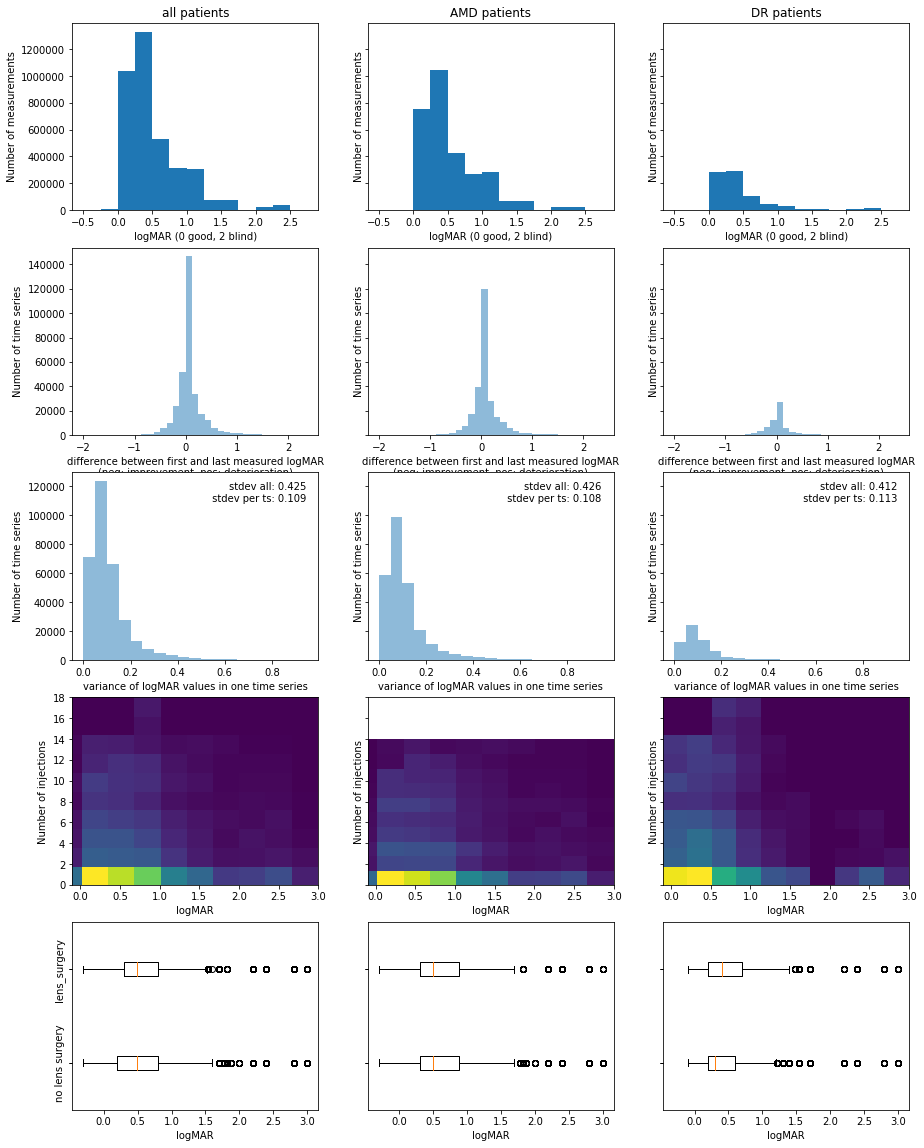

In [20]:
fig, axes = plt.subplots(5,3, sharex='row', sharey='row', figsize=(15,20))
axes[0,1].set_title('AMD patients')
axes[0,0].set_title('all patients')
axes[0,2].set_title('DR patients')
for col, sequences in zip(axes.T, [sequences_all, sequences_amd, sequences_dr]):
    plot_va(sequences, ax=col[0])
    plot_diffva(sequences, ax=col[1])
    plot_stdva(sequences, ax=col[2])
    plot_va_vs_injection(sequences, ax=col[3])
    plot_va_vs_lens_surgery(sequences, ax=col[4])
fig.savefig('sequences_for_training_va.png', dpi=300)    

In [27]:
sequences_all[0].measurements[0].oct_path

'/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler/Studies/Optical Coherence Tomography Scanner/18/Right/20170926/1.3.6.1.4.1.33437.10.4.4089432.13150897606.27916.4.1.dcm'

In [28]:
sequences_all[0].patient_id

18